# Features Summary of Water Quality Data

This dataset contains water quality measurements from various sites, with the following key features:

- **Site_Id**: Identifier for the site where the data was collected (String).
- **Unit_Id**: Identifier for the unit, mostly missing values.
- **Read_Date**: Date of the reading, indicating the time of data collection.
- **Salinity (ppt)**: Salinity levels in parts per thousand (ppt).
- **Dissolved Oxygen (mg/L)**: Concentration of dissolved oxygen in milligrams per liter.
- **pH (standard units)**: pH level of the water, measured in standard units.
- **Secchi Depth (m)**: Measurement of water transparency or clarity, in meters.
- **Water Depth (m)**: Depth of water at the site, in meters.
- **Water Temp (°C)**: Water temperature in degrees Celsius.
- **Air Temp-Celsius**: Air temperature in Celsius (has few records).
- **Air Temp (°F)**: Air temperature in Fahrenheit, more complete than the Celsius version.
- **Time (24:00)**: Time of the reading in 24-hour format.
- **Field_Tech**: Name or identifier of the field technician who took the measurement.
- **DateVerified**: Date the data was verified.
- **WhoVerified**: Name or identifier of the person who verified the data.
- **AirTemp (C)**: Air temperature in Celsius, complete and consistent with the dataset.
- **Year**: Year of data collection.

## I- Data analysis and preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.covariance import MinCovDet
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns

In [2]:
# Load the water quality dataset from data folder into a pandas DataFrame

file_path = os.path.join('..', 'data', 'BKB_WaterQualityData_2020084.csv')
df = pd.read_csv(file_path, index_col=False)

In [3]:
# Display the first few rows of the DataFrame to get an initial look at the data structure and contents
df.head()

,Site_Id,Unit_Id,Read_Date,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Depth (m),Water Temp (?C),Air Temp-Celsius,Air Temp (?F),Time (24:00),Field_Tech,DateVerified,WhoVerified,AirTemp (C),Year
0,Bay,NaN,1/3/1994,1.3,11.7,7.3,0.40,0.40,5.9,8.0,46.40,11:00,NaN,NaN,NaN,8.0,1994
1,Bay,NaN,1/31/1994,1.5,12.0,7.4,0.20,0.35,3.0,2.6,36.68,11:30,NaN,NaN,NaN,2.6,1994
2,Bay,NaN,2/7/1994,1.0,10.5,7.2,0.25,0.60,5.9,7.6,45.68,9:45,NaN,NaN,NaN,7.6,1994
3,Bay,NaN,2/23/1994,1.0,10.1,7.4,0.35,0.50,10.0,2.7,36.86,NaN,NaN,NaN,NaN,2.7,1994
4,Bay,NaN,2/28/1994,1.0,12.6,7.2,0.20,0.40,1.6,0.0,32.00,10:30,NaN,NaN,NaN,0.0,1994


In [4]:
# Convert the 'Read_Date' column to datetime format and set it as the DataFrame index for time-based analysis
df['Read_Date'] = pd.to_datetime(df['Read_Date'])
df = df.set_index('Read_Date')

In [5]:
# Display the column names of the DataFrame to understand the available data fields
df.columns

Index(['Site_Id', 'Unit_Id', 'Salinity (ppt)', 'Dissolved Oxygen (mg/L)',
       'pH (standard units)', 'Secchi Depth (m)', 'Water Depth (m)',
       'Water Temp (?C)', 'Air Temp-Celsius', 'Air Temp (?F)', 'Time (24:00)',
       'Field_Tech', 'DateVerified', 'WhoVerified', 'AirTemp (C)', 'Year'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2371 entries, 1994-01-03 to 2018-12-11
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Site_Id                  2370 non-null   object 
 1   Unit_Id                  32 non-null     object 
 2   Salinity (ppt)           2241 non-null   float64
 3   Dissolved Oxygen (mg/L)  1520 non-null   float64
 4   pH (standard units)      2276 non-null   float64
 5   Secchi Depth (m)         2298 non-null   float64
 6   Water Depth (m)          2300 non-null   float64
 7   Water Temp (?C)          2250 non-null   float64
 8   Air Temp-Celsius         85 non-null     float64
 9   Air Temp (?F)            2300 non-null   float64
 10  Time (24:00)             2308 non-null   object 
 11  Field_Tech               2332 non-null   object 
 12  DateVerified             453 non-null    object 
 13  WhoVerified              453 non-null    object 
 14  AirTem

### 1. DataFrame Overview

This DataFrame has 2,371 entries from 1994-01-03 to 2018-12-11, indexed by `Read_Date`. It includes 16 columns with various water quality parameters (e.g., Salinity, Dissolved Oxygen, pH, Water Depth, and Temperature) and metadata fields like `Site_Id` and `Field_Tech`. Several columns have missing values, and the data types include `float64`, `int64`, and `object`. Total memory usage is 314.9 KB.

In [7]:
df.isnull().sum()

Site_Id                       1
Unit_Id                    2339
Salinity (ppt)              130
Dissolved Oxygen (mg/L)     851
pH (standard units)          95
Secchi Depth (m)             73
Water Depth (m)              71
Water Temp (?C)             121
Air Temp-Celsius           2286
Air Temp (?F)                71
Time (24:00)                 63
Field_Tech                   39
DateVerified               1918
WhoVerified                1918
AirTemp (C)                   0
Year                          0
dtype: int64

### 2. Data Cleaning and resampling

To prepare the data for anomaly detection, we removed columns with a high proportion of missing values and those not relevant to our analysis. Specifically, we dropped the following columns:

- `Site_Id`, `Unit_Id`, `Air Temp-Celsius`, `Field_Tech`, `DateVerified`, and `WhoVerified`

These columns had limited information or non-numeric data that doesn’t support anomaly detection.

In [8]:
df = df.drop(columns=['Site_Id', 'Unit_Id','Air Temp-Celsius', 'Field_Tech', 'DateVerified', 'WhoVerified', 'Year']) 

For the remaining columns, we will fill missing values using the mean of each feature to ensure a complete dataset.

In [9]:
df['Salinity (ppt)'] = df['Salinity (ppt)'].fillna(df['Salinity (ppt)'].mean())
df['Dissolved Oxygen (mg/L)'] = df['Dissolved Oxygen (mg/L)'].fillna(df['Dissolved Oxygen (mg/L)'].mean())
df['pH (standard units)'] = df['pH (standard units)'].fillna(df['pH (standard units)'].mean())
df['Secchi Depth (m)'] = df['Secchi Depth (m)'].fillna(df['Secchi Depth (m)'].mean())
df['Water Depth (m)'] = df['Water Depth (m)'].fillna(df['Water Depth (m)'].mean())
df['Water Temp (?C)'] = df['Water Temp (?C)'].fillna(df['Water Temp (?C)'].mean())
df['Air Temp (?F)'] = df['Air Temp (?F)'].fillna(df['Air Temp (?F)'].mean())

In [10]:
df = df.select_dtypes(include=['number'])

In [11]:
# Resample the data to a weekly frequency, calculating the mean for each week, then interpolate missing values based on time to smooth the data

df_resampled = df.resample('W').mean()  #  resample the data to a weekly frequency, calculating the mean for each week
df = df_resampled.interpolate(method='time')

In [12]:
df.head()

,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Depth (m),Water Temp (?C),Air Temp (?F),AirTemp (C)
Read_Date,,,,,,,,
1989-05-14,0.717068,6.646263,7.500000,0.300000,0.9,17.0,62.051637,-17.777778
1989-05-21,0.717068,12.000000,7.500000,0.200000,0.6,17.5,68.900000,20.500000
1989-05-28,0.717068,6.646263,8.000000,0.400000,0.8,23.0,77.000000,25.000000
1989-06-04,0.717068,12.000000,8.000000,0.400000,0.9,25.5,84.200000,29.000000
1989-06-11,0.717068,11.107711,8.083333,0.383333,0.9,26.0,83.900000,28.833333


### 3. Feature selection

**Correlation Heatmap**

The heatmap above displays the absolute correlations between the features in our dataset. This visualization helps identify highly correlated features. In the next steps, we will use this information to remove features with high correlations, simplifying our dataset and reducing redundancy for improved analysis.

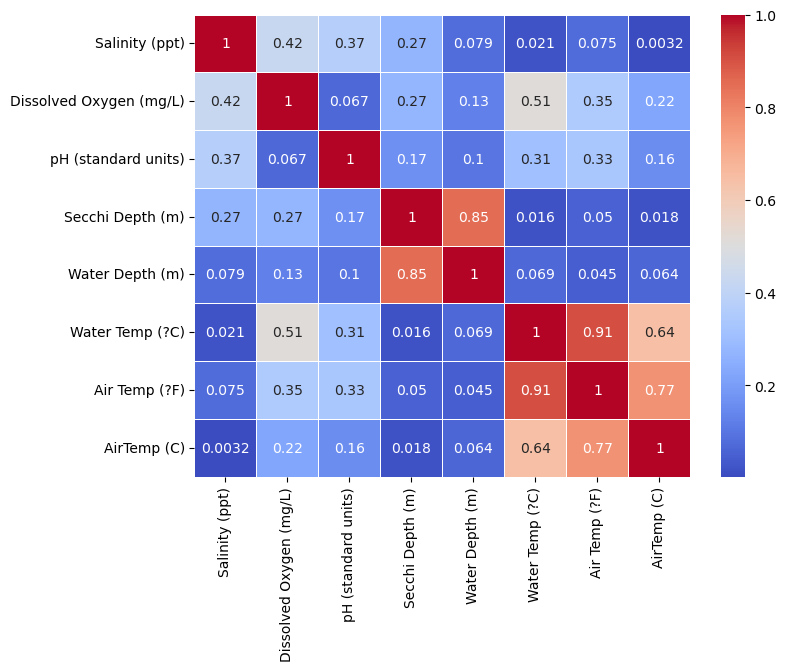

In [13]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [14]:
def correlation(df, threshold):
    '''
    Identify and return a set of column names with correlation values above a specified threshold.
    
    Parameters:
    df (DataFrame): The DataFrame containing the features to be evaluated for correlation.
    threshold (float): The correlation threshold above which features are considered highly correlated.
    
    Returns:
    set: A set containing the names of columns with correlations exceeding the specified threshold, 
         indicating that these columns may be redundant for further analysis.

    '''
    col_corr = set()  # Set of all the names of correlated columns
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [15]:
corr_features = correlation(df, 0.8)
len(set(corr_features))

2

In [16]:
select_df = df.drop(corr_features, axis=1)

In [17]:
# Display the first few rows of the new DataFrame after removing highly correlated features
select_df.head()

,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Temp (?C),AirTemp (C)
Read_Date,,,,,,
1989-05-14,0.717068,6.646263,7.500000,0.300000,17.0,-17.777778
1989-05-21,0.717068,12.000000,7.500000,0.200000,17.5,20.500000
1989-05-28,0.717068,6.646263,8.000000,0.400000,23.0,25.000000
1989-06-04,0.717068,12.000000,8.000000,0.400000,25.5,29.000000
1989-06-11,0.717068,11.107711,8.083333,0.383333,26.0,28.833333


### 4. Data visualization

In [18]:
# Create interactive time-series line plots for each feature in select_df, arranged in a grid layout

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.palettes import Set1_6

output_notebook()


plots = []
colors = Set1_6
for i, column in enumerate(select_df.columns):

    p = figure(x_axis_type="datetime", title=column, width=500, height=200)
    color = colors[i % len(colors)]
    p.line(select_df.index, select_df[column], line_width=2, color=color)

    plots.append(p)

grid = gridplot(plots, ncols=2)

show(grid)

Loading BokehJS ...

### 5. Data Standardization

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the selected columns
df_scaled = scaler.fit_transform(select_df[select_df.columns])

# Display the standardized data
df_scaled = pd.DataFrame(df_scaled, columns=select_df.columns)
df_scaled.head()

,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Temp (?C),AirTemp (C)
0,-0.222081,-0.293043,0.429936,-0.613595,-0.101129,-3.122130
1,-0.222081,2.273111,0.429936,-0.952922,-0.034617,0.532294
2,-0.222081,-0.293043,1.249761,-0.274268,0.697018,0.961915
3,-0.222081,2.273111,1.249761,-0.274268,1.029580,1.343799
4,-0.222081,1.845418,1.386399,-0.330823,1.096092,1.327887


### 6. Boxplots

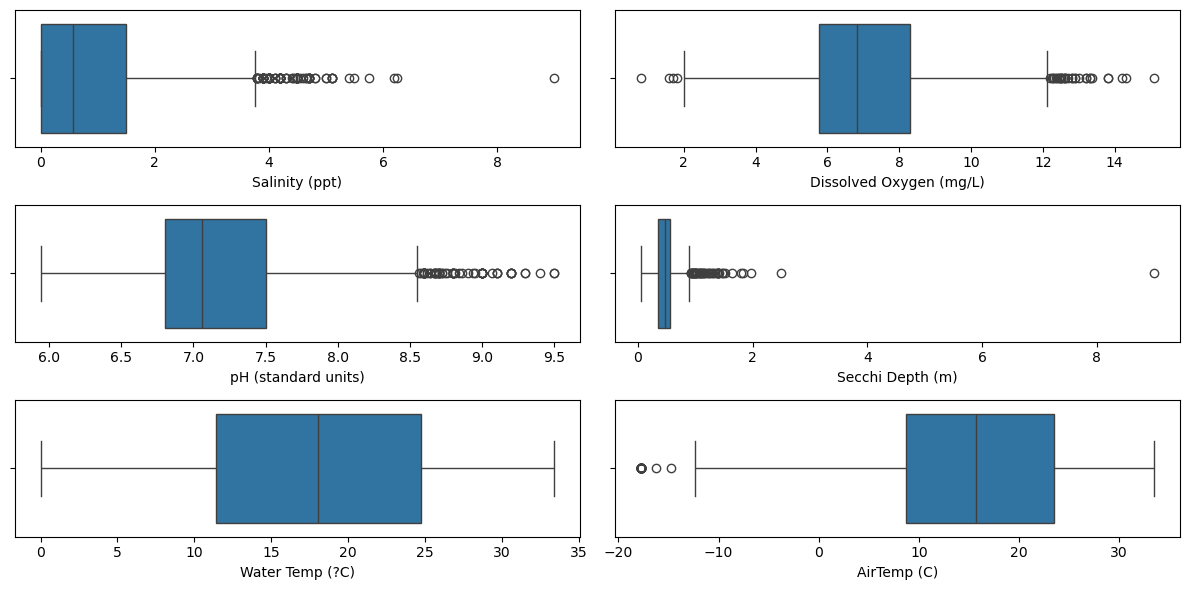

In [20]:
# Create box plots for each feature in select_df, arranged in a 3x2 grid layout to visualize data distributions and outliers

f, ax= plt.subplots(3,2 , figsize=(12,6))
ax = ax.flatten()

for index, cols in enumerate(select_df.columns):
    sns.boxplot(data = select_df, x = cols , ax = ax[index])
    
plt.tight_layout()
plt.show()

## Algorithm 1: Isolation Forest

In [ ]:
for column in select_df.columns:
    model = IsolationForest(contamination=0.04, random_state=42)
    
    select_df[f'{column}_anomaly'] = model.fit_predict(select_df[[column]])
    
    select_df[f'{column}_anomaly'] = select_df[f'{column}_anomaly'] == -1

In [ ]:
fig = make_subplots(rows=3, cols=2,     subplot_titles=[
        'Salinity (ppt)', 'Dissolved Oxygen (mg/L)', 
        'pH (standard units)', 'Secchi Depth (m)', 
        'Water Temp (°C)', 'Air Temp (°C)'
    ])
fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Salinity (ppt)'], mode='lines', name='Salinity (ppt)'), row=1, col=1)
fig.add_trace(go.Scatter(x=select_df[select_df['Salinity (ppt)_anomaly']].index, y=select_df[select_df['Salinity (ppt)_anomaly']]['Salinity (ppt)'], mode='markers',
                        marker=dict(color='red', size=7)), row=1, col=1)
fig.update_xaxes(title_text="years")
fig.update_yaxes()

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Dissolved Oxygen (mg/L)'], mode='lines', name='Dissolved Oxygen (mg/L)'), row=1, col=2)
fig.add_trace(go.Scatter(x=select_df[select_df['Dissolved Oxygen (mg/L)_anomaly']].index, y=select_df[select_df['Dissolved Oxygen (mg/L)_anomaly']]['Dissolved Oxygen (mg/L)'], mode='markers',
                        marker=dict(color='red', size=7)), row=1, col=2)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['pH (standard units)'], mode='lines', name='pH (standard units)'), row=2, col=1)
fig.add_trace(go.Scatter(x=select_df[select_df['pH (standard units)_anomaly']].index, y=select_df[select_df['pH (standard units)_anomaly']]['pH (standard units)'], mode='markers',
                          marker=dict(color='red', size=7)), row=2, col=1)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Secchi Depth (m)'], mode='lines', name='Secchi Depth (m)'), row=2, col=2)
fig.add_trace(go.Scatter(x=select_df[select_df['Secchi Depth (m)_anomaly']].index, y=select_df[select_df['Secchi Depth (m)_anomaly']]['Secchi Depth (m)'], mode='markers',
                        marker=dict(color='red', size=7)), row=2, col=2)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Water Temp (?C)'], mode='lines', name='Water Temp (?C)'), row=3, col=1)
fig.add_trace(go.Scatter(x=select_df[select_df['Water Temp (?C)_anomaly']].index, y=select_df[select_df['Water Temp (?C)_anomaly']]['Water Temp (?C)'], mode='markers',
                        marker=dict(color='red', size=7)), row=3, col=1)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['AirTemp (C)'], mode='lines', name='AirTemp (C)'), row=3, col=2)
fig.add_trace(go.Scatter(x=select_df[select_df['AirTemp (C)_anomaly']].index, y=select_df[select_df['AirTemp (C)_anomaly']]['AirTemp (C)'], mode='markers',
                        marker=dict(color='red', size=7)), row=3, col=2)

fig.update_layout(showlegend=False)

fig.update_layout(height=800, width=1000)
fig.show()

## Algorithm 2: Robust Covariance

In [ ]:
for column in select_df.columns:
    mcd = MinCovDet(random_state=42).fit(column)
    
    select_df[f'{column}_anomaly'] = model.fit_predict(select_df[[column]])

    select_df['mahalanobis'] = mcd.mahalanobis(select_df)
    
    select_df[f'{column}_anomaly'] = select_df[f'{column}_anomaly'] == -1

In [21]:
# Ensure that only numeric columns are used for MCD
select_df = select_df.select_dtypes(include=[np.number])


# Now you can train the MCD model
mcd = MinCovDet(random_state=42).fit(select_df)
select_df['mahalanobis'] = mcd.mahalanobis(select_df)

# Set threshold for anomaly detection (97.5th percentile)
threshold = np.percentile(select_df['mahalanobis'], 97.5)
select_df['anomaly_mcd'] = select_df['mahalanobis'] > threshold

print(f"Threshold for Mahalanobis distance (97.5th percentile): {threshold}")
print("Anomalies detected:", select_df['anomaly_mcd'].sum())


Threshold for Mahalanobis distance (97.5th percentile): 201.02604043447258
Anomalies detected: 40


In [28]:
fig = make_subplots(rows=3, cols=2,     subplot_titles=[
        'Salinity (ppt)', 'Dissolved Oxygen (mg/L)', 
        'pH (standard units)', 'Secchi Depth (m)', 
        'Water Temp (°C)', 'Air Temp (°C)'
    ])
fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Salinity (ppt)'], mode='lines', name='Salinity (ppt)'), row=1, col=1)
fig.add_trace(go.Scatter(x=select_df[select_df['Salinity (ppt)_anomaly']].index, y=select_df[select_df['Salinity (ppt)_anomaly']]['Salinity (ppt)'], mode='markers',
                        marker=dict(color='red', size=7)), row=1, col=1)
fig.update_xaxes(title_text="years")
fig.update_yaxes()

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Dissolved Oxygen (mg/L)'], mode='lines', name='Dissolved Oxygen (mg/L)'), row=1, col=2)
fig.add_trace(go.Scatter(x=select_df[select_df['Dissolved Oxygen (mg/L)_anomaly']].index, y=select_df[select_df['Dissolved Oxygen (mg/L)_anomaly']]['Dissolved Oxygen (mg/L)'], mode='markers',
                        marker=dict(color='red', size=7)), row=1, col=2)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['pH (standard units)'], mode='lines', name='pH (standard units)'), row=2, col=1)
fig.add_trace(go.Scatter(x=select_df[select_df['pH (standard units)_anomaly']].index, y=select_df[select_df['pH (standard units)_anomaly']]['pH (standard units)'], mode='markers',
                          marker=dict(color='red', size=7)), row=2, col=1)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Secchi Depth (m)'], mode='lines', name='Secchi Depth (m)'), row=2, col=2)
fig.add_trace(go.Scatter(x=select_df[select_df['Secchi Depth (m)_anomaly']].index, y=select_df[select_df['Secchi Depth (m)_anomaly']]['Secchi Depth (m)'], mode='markers',
                        marker=dict(color='red', size=7)), row=2, col=2)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['Water Temp (?C)'], mode='lines', name='Water Temp (?C)'), row=3, col=1)
fig.add_trace(go.Scatter(x=select_df[select_df['Water Temp (?C)_anomaly']].index, y=select_df[select_df['Water Temp (?C)_anomaly']]['Water Temp (?C)'], mode='markers',
                        marker=dict(color='red', size=7)), row=3, col=1)

fig.add_trace(go.Scatter(x=select_df.index, y=select_df['AirTemp (C)'], mode='lines', name='AirTemp (C)'), row=3, col=2)
fig.add_trace(go.Scatter(x=select_df[select_df['AirTemp (C)_anomaly']].index, y=select_df[select_df['AirTemp (C)_anomaly']]['AirTemp (C)'], mode='markers',
                        marker=dict(color='red', size=7)), row=3, col=2)

fig.update_layout(showlegend=False)

fig.update_layout(height=800, width=1000)
fig.show()

KeyError: 'Salinity (ppt)_anomaly'